# Importing & Installing Libraries

In [5]:
!pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 44.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.6 MB/s eta 0:00:00


In [61]:
import pickle
import pandas as pd
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import Adamax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import music21
from music21 import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline


# Functions

## Sequencer

The following functions are used for preprocessing the input sequence of musical notes (integer encoded notes, v1; raw sequence of notes, v2) for training a deep learning model. The functions split the input notes into windows of size window_size, where each window serves as input features and the next note in the sequence serves as the target. 

The output of the function is a list of windows.

In [7]:
def sequence_splitterv1(integer_encoded_sequence, window_size):
    network_input = []
    network_output = []
    n_vocab = len(set(integer_encoded_sequence))

    for i in range(0, len(integer_encoded_sequence) - window_size, 1):
        sequence_in = integer_encoded_sequence[i:i + window_size]
        sequence_out = integer_encoded_sequence[i + window_size]
        network_input.append(sequence_in)
        network_output.append(sequence_out)

    n_patterns = len(network_input)
    
    network_input = np.reshape(network_input, (n_patterns, window_size, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    network_output = to_categorical(network_output)
    
    return network_input, network_output

In [8]:
def sequence_splitterv2(notes, window_size):
    features = []
    targets = []
    
    for i in range(0, len(notes) - window_size, 1):
        feature = notes[i:i + window_size]
        target = notes[i + window_size]
        features.append([mapping[j] for j in feature])
        targets.append(mapping[target])
        
    
    return features, targets

## Generation of music (predicting sequence based on random prompt)

The function 'generate_melody' prompts model to generate (predict) a sequence with length *n*. Due to softmax activation function used in models, the prediction with highest probability is chosen and later translated back to pitch name and the sequence with pitch names are transformed into a midi stream (chords_n_notes).


In [145]:
def chords_n_notes(snippet):
    melody = []
    offset = 0 
    for i in snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    melody_midi = stream.Stream(melody)   
    return melody_midi

In [ ]:
def generate_melody(model, n_notes_to_generate):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    music = ""
    generated_notes =[]
    for i in range(n_notes_to_generate):
        seed = seed.reshape(1,window_size,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(type_size)   
        generated_notes.append(index)
        music = [reverse_mapping[char] for char in generated_notes]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
        
    # list of chords/notes to midi stream
    melody = chords_n_notes(music)
    melody_midi = stream.Stream(melody)   
    return music, melody_midi

# Importing and preprocessing data

In [124]:
with open('/kaggle/input/lstmproject/integer_encoded_notes', 'rb') as f:
    encoded_notes = pickle.load(f)
    

with open('/kaggle/input/pitchbased/pitchbased_notes', 'rb') as f:
    pitchbased_notes = pickle.load(f)

In [125]:
# Vocab exploration

token_size = len(pitchbased_notes)
type_size = len(set(pitchbased_notes))
print(f'Total number of notes: {token_size}')
print(f'Total number of distinct notes: {type_size}')

# The following code eliminates notes that occur less than 40 times in the dataset.
    
rare_note = []
for index, (key, value) in enumerate(Counter(pitchbased_notes).items()):
    if value < 20:
        m =  key
        rare_note.append(m)
        
print(f'Total number of notes that occur less than 40 times: {len(rare_note)}')
    
for element in pitchbased_notes:
    if element in rare_note:
        pitchbased_notes.remove(element)

print(f'Number of notes after cleaning: {len(pitchbased_notes)}')

Total number of notes: 48686
Total number of distinct notes: 331
Total number of notes that occur less than 40 times: 161
Number of notes after cleaning: 48086


In [126]:
unique_notes = sorted(list(set(pitchbased_notes)))

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(unique_notes))
reverse_mapping = dict((i, c) for i, c in enumerate(unique_notes))

# Generating the training data

The specified hyperparemeters in the following section belongs only to the last trained model as the following section are repeatedly used and modified to experiment and generate new models.

In [127]:
window_size = 120

features, targets = sequence_splitterv2(pitchbased_notes, window_size)

In [128]:
targets_length = len(targets)
print("Total number of sequences in the dataset:", targets_length)

Total number of sequences in the dataset: 47966


In [129]:
# reshape X and normalize
X = (np.reshape(features, (targets_length, window_size, 1)))/ float(type_size)
# one hot encode the output variable
y = to_categorical(targets) 

In [130]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=16)

In [131]:
X_train.shape

(38372, 120, 1)

# Establishing LSTM Models

In [132]:
adamax_opt = Adamax(learning_rate=0.01)
rmsprop = 'rmsprop'

## Goldberg Model (based on Kapoor)

In [42]:
#Initialising the Model
goldberg = Sequential()
#Adding layers
goldberg.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
goldberg.add(Dropout(0.1))
goldberg.add(LSTM(256))
goldberg.add(Dense(256))
goldberg.add(Dropout(0.1))
goldberg.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
julian.compile(loss='categorical_crossentropy', optimizer=adamax_opt)

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f9344a2fd40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


## Elise (added layers, rmsprop)

In [143]:
elise = Sequential()
elise.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
elise.add(Dropout(0.2))
elise.add(LSTM(256, return_sequences=True))
elise.add(Dropout(0.2))
elise.add(LSTM(256))
elise.add(Dense(256))
elise.add(Dropout(0.2))
elise.add(Dense(y.shape[1], activation='softmax'))
elise.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Training models

The following part is used repeatedly to generate different models based on various hyperparameters specified previously in both model-level and dataset generation level. The number epochs and batch size reflect the last trained model's hyperparameters.

In [ ]:
epochs = 100
batch_size = 256

In [144]:
history = elise.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/100
150/150 [==============================] - 18s 96ms/step - loss: 4.5697
Epoch 2/100
150/150 [==============================] - 15s 99ms/step - loss: 4.4517
Epoch 3/100
150/150 [==============================] - 15s 101ms/step - loss: 4.4254
Epoch 4/100
150/150 [==============================] - 15s 101ms/step - loss: 4.4110
Epoch 5/100
150/150 [==============================] - 15s 101ms/step - loss: 4.3957
Epoch 6/100
150/150 [==============================] - 15s 102ms/step - loss: 4.3782
Epoch 7/100
150/150 [==============================] - 15s 101ms/step - loss: 4.3622
Epoch 8/100
150/150 [==============================] - 15s 101ms/step - loss: 4.3404
Epoch 9/100
150/150 [==============================] - 15s 101ms/step - loss: 4.3112
Epoch 10/100
150/150 [==============================] - 15s 101ms/step - loss: 4.2772
Epoch 11/100
150/150 [==============================] - 15s 101ms/step - loss: 4.2378
Epoch 12/100
150/150 [==============================] - 15s 101ms

[Text(0.5, 0, 'Epochs')]

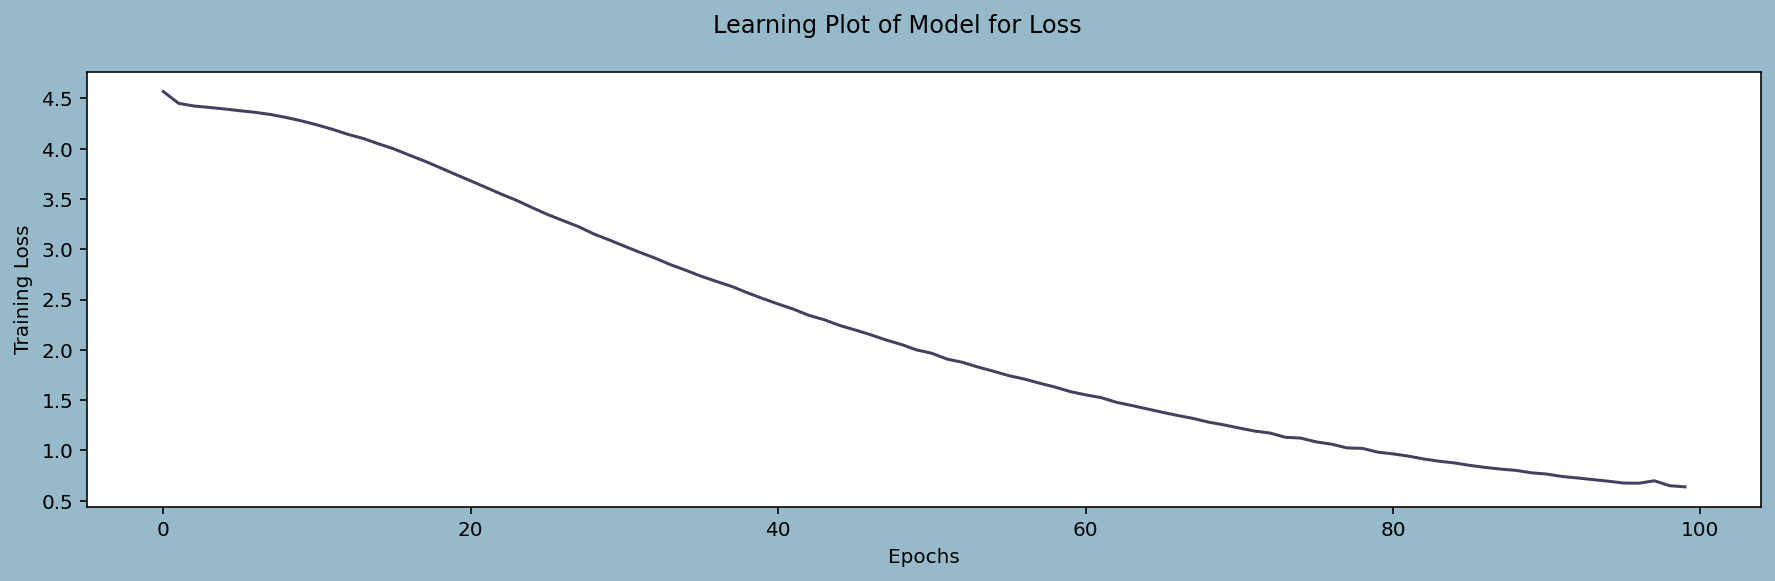

In [151]:
training_history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=training_history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# Saving & Generating

## Saving the model and its training history

In [147]:
elise.save(f'elise{epochs}w{window_size}b{batch_size}_rmsprop.h5')
training_history_df.to_csv(f'elise{epochs}w{window_size}b{batch_size}_rmsprop.csv', sep='\t')

## Generating music and writing to a midi file

In [149]:
music_notes, melody = generate_melody(model, 100)

In [150]:
#To save the generated melody
melody.write('midi','elisev3_melody2.mid')

'elisev3_melody2.mid'